# torchaudio Tutorial

PyTorch is an open source deep learning platform that provides a
seamless path from research prototyping to production deployment with
GPU support.

Significant effort in solving machine learning problems goes into data
preparation. ``torchaudio`` leverages PyTorch’s GPU support, and provides
many tools to make data loading easy and more readable. In this
tutorial, we will see how to load and preprocess data from a simple
dataset.



In [3]:
import torch
import torchaudio
import matplotlib.pyplot as plt

In [17]:
plt.rcParams['figure.figsize'] = 12, 8
plt.style.use('seaborn-dark')

## Opening a file

``torchaudio`` also supports loading sound files in the wav and mp3 format. We
call waveform the resulting raw audio signal.




In [8]:
!wget https://raw.githubusercontent.com/vincentqb/tutorials/34696686dcbc032ee328591d8b65517e7c2d7de2/_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav

--2020-09-10 16:34:36--  https://raw.githubusercontent.com/vincentqb/tutorials/34696686dcbc032ee328591d8b65517e7c2d7de2/_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1107596 (1.1M) [audio/wav]
Saving to: ‘steam-train-whistle-daniel_simon-converted-from-mp3.wav’

steam-train-whistle 100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2020-09-10 16:34:36 (18.5 MB/s) - ‘steam-train-whistle-daniel_simon-converted-from-mp3.wav’ saved [1107596/1107596]



Shape of waveform: torch.Size([2, 276858])
Sample rate of waveform: 44100


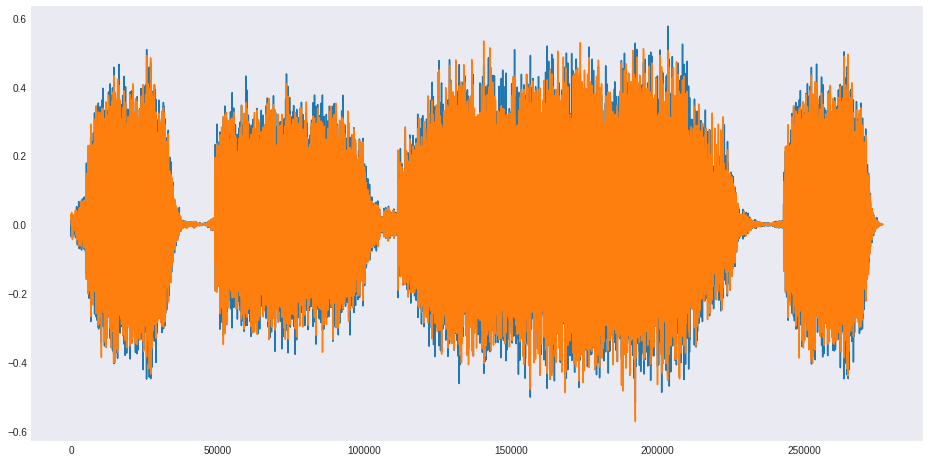

In [18]:
filename = "steam-train-whistle-daniel_simon-converted-from-mp3.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure(figsize=(16, 8))
plt.plot(waveform.t().numpy());

When you load a file in ``torchaudio``, you can optionally specify the backend to use either 
[SoX](https://pypi.org/project/sox/) or [SoundFile](https://pypi.org/project/SoundFile/)
via ``torchaudio.set_audio_backend``. These backends are loaded lazily when needed.

``torchaudio`` also makes JIT compilation optional for functions, and uses ``nn.Module`` where possible.



## Transformations

``torchaudio`` supports a growing list of
[transformations](https://pytorch.org/audio/transforms.html)

-  **Resample**: Resample waveform to a different sample rate.
-  **Spectrogram**: Create a spectrogram from a waveform.
-  **GriffinLim**: Compute waveform from a linear scale magnitude spectrogram using 
   the Griffin-Lim transformation.
-  **ComputeDeltas**: Compute delta coefficients of a tensor, usually a spectrogram.
-  **ComplexNorm**: Compute the norm of a complex tensor.
-  **MelScale**: This turns a normal STFT into a Mel-frequency STFT,
   using a conversion matrix.
-  **AmplitudeToDB**: This turns a spectrogram from the
   power/amplitude scale to the decibel scale.
-  **MFCC**: Create the Mel-frequency cepstrum coefficients from a
   waveform.
-  **MelSpectrogram**: Create MEL Spectrograms from a waveform using the
   STFT function in PyTorch.
-  **MuLawEncoding**: Encode waveform based on mu-law companding.
-  **MuLawDecoding**: Decode mu-law encoded waveform.
-  **TimeStretch**: Stretch a spectrogram in time without modifying pitch for a given rate.
-  **FrequencyMasking**: Apply masking to a spectrogram in the frequency domain.
-  **TimeMasking**: Apply masking to a spectrogram in the time domain.

Each transform supports batching: you can perform a transform on a single raw 
audio signal or spectrogram, or many of the same shape.

Since all transforms are ``nn.Modules`` or ``jit.ScriptModules``, they can be
used as part of a neural network at any point.




To start, we can look at the log of the spectrogram on a log scale.




Shape of spectrogram: torch.Size([2, 201, 1385])


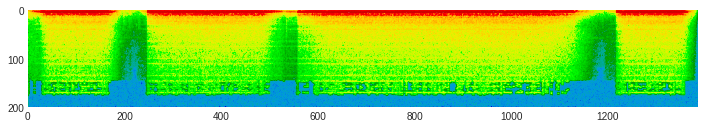

In [23]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='nipy_spectral');

Or we can look at the Mel Spectrogram on a log scale.




Shape of spectrogram: torch.Size([2, 128, 1385])


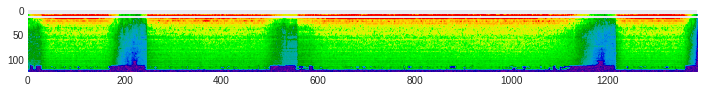

In [24]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='nipy_spectral');

We can resample the waveform, one channel at a time.




Shape of transformed waveform: torch.Size([1, 27686])


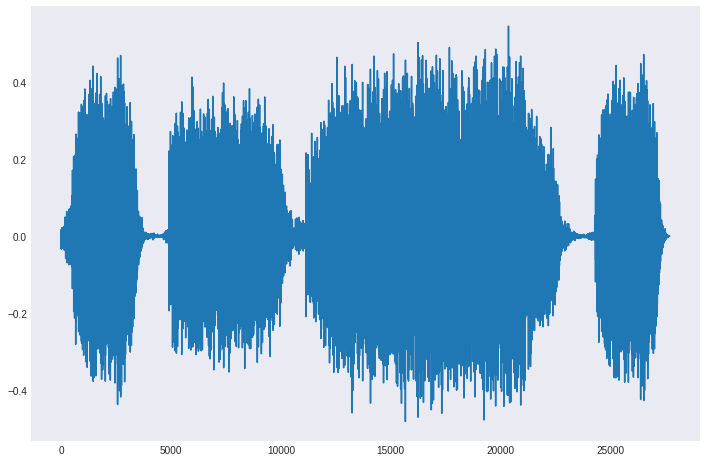

In [25]:
new_sample_rate = sample_rate/10

# Since Resample applies to a single channel, we resample first channel here
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy());

As another example of transformations, we can encode the signal based on
Mu-Law enconding. But to do so, we need the signal to be between -1 and
1. Since the tensor is just a regular PyTorch tensor, we can apply
standard operators on it.




In [26]:
# Let's check if the tensor is in the interval [-1,1]
print("Min of waveform: {}\nMax of waveform: {}\nMean of waveform: {}".format(waveform.min(), waveform.max(), waveform.mean()))

Min of waveform: -0.572845458984375
Max of waveform: 0.575958251953125
Mean of waveform: 9.293758921558037e-05


Since the waveform is already between -1 and 1, we do not need to
normalize it.




In [27]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

# Let's normalize to the full interval [-1,1]
# waveform = normalize(waveform)

Let’s apply encode the waveform.




Shape of transformed waveform: torch.Size([2, 276858])


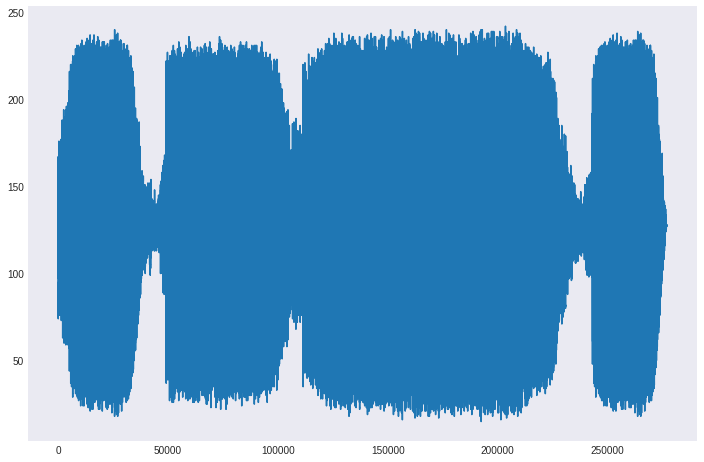

In [28]:
transformed = torchaudio.transforms.MuLawEncoding()(waveform)

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy());

And now decode.




Shape of recovered waveform: torch.Size([2, 276858])


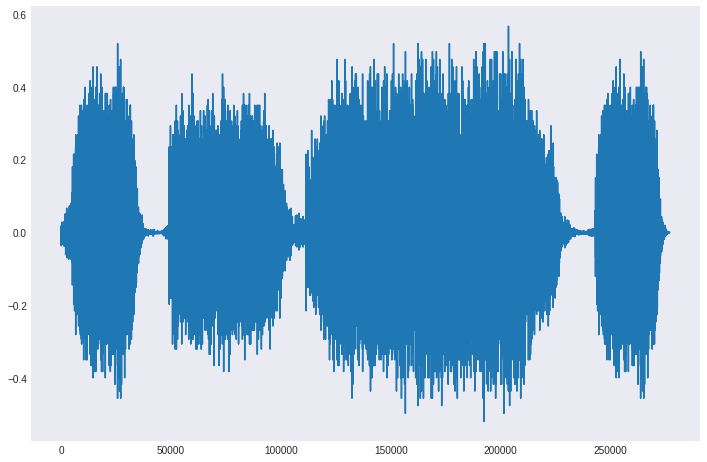

In [29]:
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)

print("Shape of recovered waveform: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy());

We can finally compare the original waveform with its reconstructed
version.




In [30]:
# Compute median relative difference
err = ((waveform-reconstructed).abs() / waveform.abs()).median()

print("Median relative difference between original and MuLaw reconstucted signals: {:.2%}".format(err))

Median relative difference between original and MuLaw reconstucted signals: 1.28%


Functional
---------------

The transformations seen above rely on lower level stateless functions for their computations. 
These functions are available under ``torchaudio.functional``. The complete list is available 
[here](https://pytorch.org/audio/functional.html) and includes:

-  **istft**: Inverse short time Fourier Transform.
-  **gain**: Applies amplification or attenuation to the whole waveform.
-  **dither**: Increases the perceived dynamic range of audio stored at a
   particular bit-depth.
-  **compute_deltas**: Compute delta coefficients of a tensor.
-  **equalizer_biquad**: Design biquad peaking equalizer filter and perform filtering.
-  **lowpass_biquad**: Design biquad lowpass filter and perform filtering.
-  **highpass_biquad**:Design biquad highpass filter and perform filtering.

For example, let's try the `mu_law_encoding` functional:



Shape of transformed waveform: torch.Size([2, 276858])


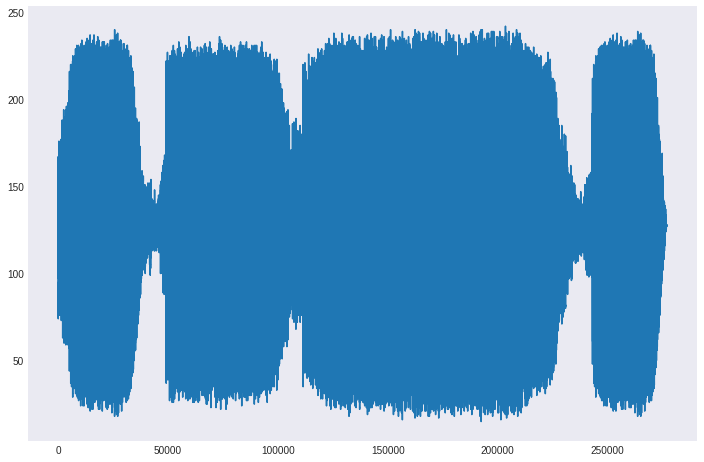

In [31]:
mu_law_encoding_waveform = torchaudio.functional.mu_law_encoding(waveform, quantization_channels=256)

print("Shape of transformed waveform: {}".format(mu_law_encoding_waveform.size()))

plt.figure()
plt.plot(mu_law_encoding_waveform[0,:].numpy());

You can see how the output fron ``torchaudio.functional.mu_law_encoding`` is the same as 
the output from ``torchaudio.transforms.MuLawEncoding``.

Now let's experiment with a few of the other functionals and visualize their output. Taking our 
spectogram, we can compute it's deltas:



Shape of computed deltas: torch.Size([2, 128, 1385])


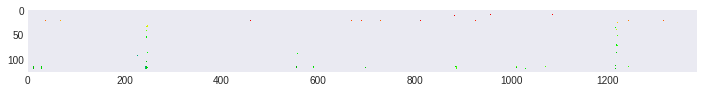

In [36]:
computed = torchaudio.functional.compute_deltas(specgram.contiguous(), win_length=3)
print("Shape of computed deltas: {}".format(computed.shape))

plt.figure()
plt.imshow(computed.log2()[0,:,:].detach().numpy(), cmap='nipy_spectral');

We can take the original waveform and apply different effects to it.




In [37]:
gain_waveform = torchaudio.functional.gain(waveform, gain_db=5.0)
print("Min of gain_waveform: {}\nMax of gain_waveform: {}\nMean of gain_waveform: {}".format(gain_waveform.min(), gain_waveform.max(), gain_waveform.mean()))

dither_waveform = torchaudio.functional.dither(waveform)
print("Min of dither_waveform: {}\nMax of dither_waveform: {}\nMean of dither_waveform: {}".format(dither_waveform.min(), dither_waveform.max(), dither_waveform.mean()))

Min of gain_waveform: -1.0186792612075806
Max of gain_waveform: 1.024214744567871
Mean of gain_waveform: 0.0001652689534239471
Min of dither_waveform: -0.572784423828125
Max of dither_waveform: 0.575927734375
Mean of dither_waveform: 0.00010744280007202178


Another example of the capabilities in ``torchaudio.functional`` are applying filters to our
waveform. Applying the lowpass biquad filter to our waveform will output a new waveform with 
the signal of the frequency modified.



Min of lowpass_waveform: -0.5595059990882874
Max of lowpass_waveform: 0.5595012307167053
Mean of lowpass_waveform: 9.293769835494459e-05


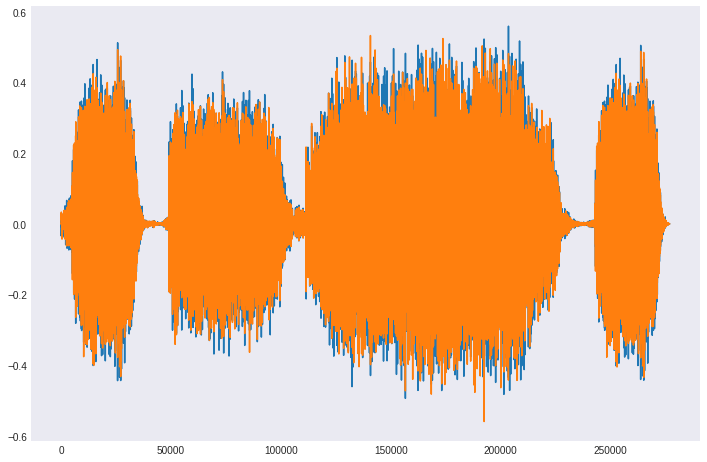

In [38]:
lowpass_waveform = torchaudio.functional.lowpass_biquad(waveform, sample_rate, cutoff_freq=3000)

print("Min of lowpass_waveform: {}\nMax of lowpass_waveform: {}\nMean of lowpass_waveform: {}".format(lowpass_waveform.min(), lowpass_waveform.max(), lowpass_waveform.mean()))

plt.figure()
plt.plot(lowpass_waveform.t().numpy());

We can also visualize a waveform with the highpass biquad filter.




Min of highpass_waveform: -0.11269102990627289
Max of highpass_waveform: 0.10451897978782654
Mean of highpass_waveform: -1.1749458177223726e-11


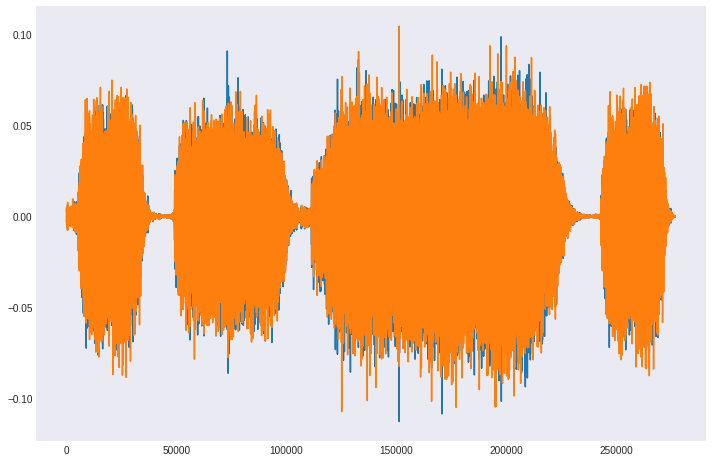

In [39]:
highpass_waveform = torchaudio.functional.highpass_biquad(waveform, sample_rate, cutoff_freq=2000)

print("Min of highpass_waveform: {}\nMax of highpass_waveform: {}\nMean of highpass_waveform: {}".format(highpass_waveform.min(), highpass_waveform.max(), highpass_waveform.mean()))

plt.figure()
plt.plot(highpass_waveform.t().numpy());

## Migrating to torchaudio from Kaldi

Users may be familiar with
[Kaldi](http://github.com/kaldi-asr/kaldi), a toolkit for speech recognition. ``torchaudio`` offers compatibility with it in ``torchaudio.kaldi_io``. It can indeed read from kaldi scp, or ark file or streams with:

-  read_vec_int_ark
-  read_vec_flt_scp
-  read_vec_flt_arkfile/stream
-  read_mat_scp
-  read_mat_ark

``torchaudio`` provides Kaldi-compatible transforms for ``spectrogram``,
``fbank``, ``mfcc``, and ``resample_waveform with the benefit of GPU support, see
`here <compliance.kaldi.html>`__ for more information.




Shape of spectrogram: torch.Size([1383, 201])


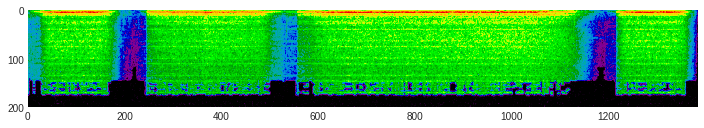

In [40]:
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}

specgram = torchaudio.compliance.kaldi.spectrogram(waveform, **params)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.t().numpy(), cmap='nipy_spectral');

We also support computing the filterbank features from waveforms,
matching Kaldi’s implementation.




Shape of fbank: torch.Size([1383, 23])


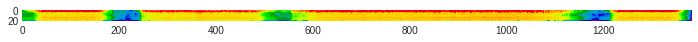

In [41]:
fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)

print("Shape of fbank: {}".format(fbank.size()))

plt.figure()
plt.imshow(fbank.t().numpy(), cmap='nipy_spectral');

You can create mel frequency cepstral coefficients from a raw audio signal
This matches the input/output of Kaldi’s compute-mfcc-feats.




Shape of mfcc: torch.Size([1383, 13])


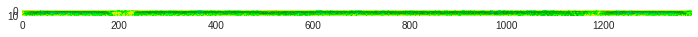

In [42]:
mfcc = torchaudio.compliance.kaldi.mfcc(waveform, **params)

print("Shape of mfcc: {}".format(mfcc.size()))

plt.figure()
plt.imshow(mfcc.t().numpy(), cmap='nipy_spectral');

## Available Datasets

If you do not want to create your own dataset to train your model, ``torchaudio`` offers a unified dataset interface. This interface supports lazy-loading of files to memory, download and extract functions, and datasets to build models.

The datasets ``torchaudio`` currently supports are:

-  **VCTK**: Speech data uttered by 109 native speakers of English with various accents
   ([Read more here](https://homepages.inf.ed.ac.uk/jyamagis/page3/page58/page58.html)).
-  **Yesno**: Sixty recordings of one individual saying yes or no in Hebrew; each
   recording is eight words long ([Read more here](https://www.openslr.org/1/)).
-  **Common Voice**: An open source, multi-language dataset of voices that anyone can use
   to train speech-enabled applications ([Read more here](https://voice.mozilla.org/en/datasets)).
-  **LibriSpeech**: Large-scale (1000 hours) corpus of read English speech ([Read more here](http://www.openslr.org/12)).





Waveform: tensor([[2.0752e-03, 1.7700e-03, 1.7395e-03,  ..., 9.1553e-04, 4.5776e-04,
         6.1035e-05]])
Sample rate: 8000
Labels: [0, 0, 1, 1, 1, 0, 0, 1]


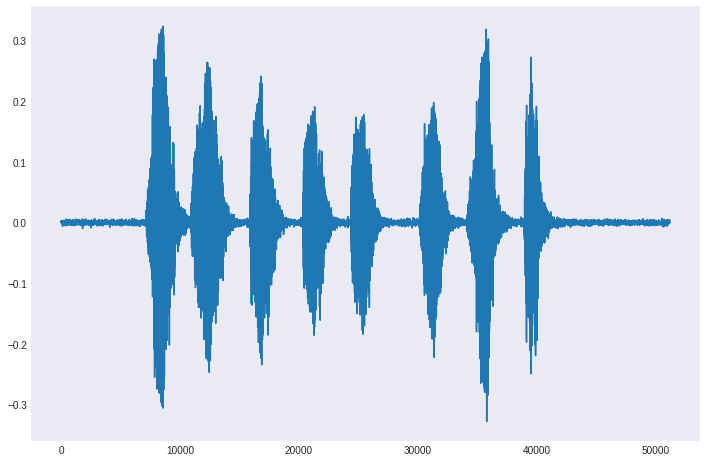

In [43]:
yesno_data = torchaudio.datasets.YESNO('./', download=True)

# A data point in Yesno is a tuple (waveform, sample_rate, labels) where labels is a list of integers with 1 for yes and 0 for no.

# Pick data point number 3 to see an example of the the yesno_data:
n = 3
waveform, sample_rate, labels = yesno_data[n]

print("Waveform: {}\nSample rate: {}\nLabels: {}".format(waveform, sample_rate, labels))

plt.figure()
plt.plot(waveform.t().numpy());

Now, whenever you ask for a sound file from the dataset, it is loaded in memory only when you ask for it.
Meaning, the dataset only loads and keeps in memory the items that you want and use, saving on memory.




Conclusion
----------

We used an example raw audio signal, or waveform, to illustrate how to
open an audio file using ``torchaudio``, and how to pre-process,
transform, and apply functions to such waveform. We also demonstrated how
to use familiar Kaldi functions, as well as utilize built-in datasets to 
construct our models. Given that ``torchaudio`` is built on PyTorch,
these techniques can be used as building blocks for more advanced audio
applications, such as speech recognition, while leveraging GPUs.


